# Running membership inference attacks on the Nursery data and defending using differential privacy

In this tutorial we will show how to run black-box membership attacks on both a vanilla model and models trained with differential privacy. The attacks are taken from the ART library's inference module (https://github.com/Trusted-AI/adversarial-robustness-toolbox) and the differentially private model implementation is taken fron the Differential Privacy Library (https://github.com/IBM/differential-privacy-library).

This will be demonstrated on the Nursery dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/nursery). 

We have already preprocessed the dataset such that all categorical features are one-hot encoded, and the data was scaled using sklearn's StandardScaler.

## Load data

In [8]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from art.utils import load_nursery

train_size = 200
(x_train, y_train), (x_test, y_test), _, _ = load_nursery(test_set=0.5)
x_train = x_train[:train_size]
y_train = y_train[:train_size]
x_test = x_test[:train_size]
y_test = y_test[:train_size]

## Train logistic regression model

In [9]:
from sklearn.linear_model import LogisticRegression
from art.estimators.classification.scikitlearn import ScikitlearnLogisticRegression

model = LogisticRegression(solver="lbfgs", max_iter=1000)
model.fit(x_train, y_train)

art_classifier = ScikitlearnLogisticRegression(model)
base_model_accuracy = model.score(x_test, y_test)

print('Base model accuracy: ', base_model_accuracy)

Base model accuracy:  0.91


## Attack
### Black-box attack
The black-box attack basically trains an additional classifier (called the attack model) to predict the membership status of a sample. It can use as input to the learning process probabilities/logits or losses, depending on the type of model and provided configuration.
#### Train attack model

In [10]:
import numpy as np
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

attack = MembershipInferenceBlackBox(art_classifier, attack_model_type='rf') 

#train attack model
attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
           x_test[:attack_test_size], y_test[:attack_test_size])

#### Infer membership and check accuracy

In [11]:
# infer attacked feature
inferred_train = attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
inferred_test = attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
print('attack accuracy on training data: ', train_acc)
print('attack accuracy on test data: ', test_acc)
print('overall attack accuracy: ', acc)

attack accuracy on training data:  0.5
attack accuracy on test data:  0.5800000000000001
overall attack accuracy:  0.54


This means that for 54% of the data, membership status is inferred correctly (a little better than a random coin flip).

In [12]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

# rule-based
print('precision and recall: ', calc_precision_recall(np.concatenate((inferred_train, inferred_test)), 
                            np.concatenate((np.ones(len(inferred_train)), np.zeros(len(inferred_test))))))

precision and recall:  (0.5434782608695652, 0.5)


## Train differentially private model

In [15]:
import diffprivlib.models as dp

dp_model = dp.LogisticRegression(epsilon=5, data_norm=5)
dp_model.fit(x_train, y_train)
# print('norm: ', np.linalg.norm(x_train) )

dp_art_model = ScikitlearnLogisticRegression(dp_model)
print('DP model accuracy: ', dp_model.score(x_test, y_test))

DP model accuracy:  0.56


### Black-box attack

In [16]:
dp_attack = MembershipInferenceBlackBox(dp_art_model, attack_model_type='rf')

# train attack model
dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size],
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size])

# infer 
dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train[attack_train_size:])
dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_test_size:], y_test[attack_test_size:])

# check accuracy
dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
dp_acc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))
print('attack accuracy on training data: ', dp_train_acc)
print('attack accuracy on test data: ', dp_test_acc)
print('overall attack accuracy: ', dp_acc)

print('precision and recall: ', calc_precision_recall(np.concatenate((dp_inferred_train, dp_inferred_test)), 
                            np.concatenate((np.ones(len(dp_inferred_train)), np.zeros(len(dp_inferred_test))))))

attack accuracy on training data:  0.4
attack accuracy on test data:  0.62
overall attack accuracy:  0.51
precision and recall:  (0.5128205128205128, 0.4)


The differentially private model reduces the attack accuracy, but also completely ruins the model's accuracy.
Let's see if we can find a sweet spot where both acceptable accuracy and privacy can be acheived.

In [17]:
accuracy = []
attack_accuracy = []
epsilons = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 75.0, 100.0, 200.0]

for eps in epsilons:
    print(eps)
    dp_clf = dp.LogisticRegression(epsilon=eps, data_norm=5)
    dp_clf.fit(x_train, y_train)
    accuracy.append(dp_clf.score(x_test, y_test))
    dp_art_classifier = ScikitlearnLogisticRegression(dp_clf)
    dp_attack = MembershipInferenceBlackBox(dp_art_classifier, attack_model_type='rf')
    dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                  x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train.astype(np.float32)[attack_train_size:])
    dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_train_size:], y_test.astype(np.float32)[attack_train_size:])
    dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
    dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
    dp_acc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))
    attack_accuracy.append(dp_acc)

0.01
0.1
0.5
1.0
5.0
10.0
25.0
75.0
100.0
200.0


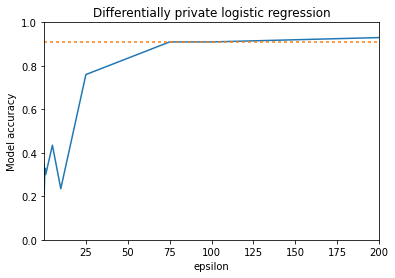

In [18]:
import matplotlib.pyplot as plt

plt.plot(epsilons, accuracy)
plt.plot(epsilons, np.ones_like(epsilons) * base_model_accuracy, dashes=[2,2], label="base model")
plt.title("Differentially private logistic regression")
plt.xlabel("epsilon")
plt.ylabel("Model accuracy")
plt.ylim(0, 1)
plt.xlim(0.1, 200)
plt.show()

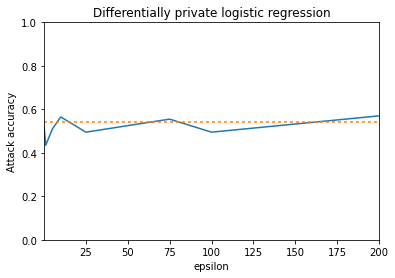

In [19]:
plt.plot(epsilons, attack_accuracy)
plt.plot(epsilons, np.ones_like(epsilons) * acc, dashes=[2,2], label="base model")
plt.title("Differentially private logistic regression")
plt.xlabel("epsilon")
plt.ylabel("Attack accuracy")
plt.ylim(0, 1)
plt.xlim(0.1, 200)
plt.show()

Looks like epsilon=25 is a good choice.

In [21]:
dp_model = dp.LogisticRegression(epsilon=25, data_norm=5)
dp_model.fit(x_train, y_train)

dp_art_classifier = ScikitlearnLogisticRegression(dp_model)
print('DP model accuracy with eps=100: ', dp_model.score(x_test, y_test))

dp_attack = MembershipInferenceBlackBox(dp_art_classifier, attack_model_type='rf')
dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train.astype(np.float32)[attack_train_size:])
dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_test_size:], y_test.astype(np.float32)[attack_test_size:])
dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
dp_acc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))
    
print('DP model attack accuracy with eps=100: ', dp_acc)

DP model accuracy with eps=100:  0.795
DP model attack accuracy with eps=100:  0.52
